<a href="https://colab.research.google.com/github/jrakhshanda/Text-Mining/blob/main/roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers
!pip install tokenizers
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
#!export XLA_USE_BF16=1

     |████████████████████████████████| 1.5MB 6.9MB/s 
     |████████████████████████████████| 890kB 22.1MB/s 
     |████████████████████████████████| 2.9MB 28.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=553695b3bf3228e9a32d68a1330207444f07937390b2708ba7b9c5272b39fcd0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
#df, test = model_selection.train_test_split(df_train,test_size=0.1)
#test.to_csv('/content/drive/MyDrive/BERT_files/test_fold.csv')

#df["kfold"] = -1
#df = df.sample(frac=1).reset_index(drop=True)

#kf = model_selection.StratifiedKFold(n_splits=5)

#for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df.sentiment.values)):
#    print(len(trn_), len(val_))
#    df.loc[val_, 'kfold'] = fold

#df.to_csv("/content/drive/MyDrive/RoBERTa_files/train_fold.csv", index=False)
#test.to_csv("/content/drive/MyDrive/RoBERTa_files/test_fold.csv", index=False)

In [5]:
import os
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import *
from transformers import AdamW, get_linear_schedule_with_warmup
import tokenizers

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Configuration

In [7]:
from tokenizers import ByteLevelBPETokenizer
class config:
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 32
    EPOCHS = 3
    PATH = '/content/drive/MyDrive/RoBERTa_files'
    TRAINING_FILE = pd.read_csv("/content/drive/MyDrive/RoBERTa_files/train_folds.csv",keep_default_na=False)
    TEST_FILE =  pd.read_csv("/content/drive/MyDrive/RoBERTa_files/test.csv")
    MAX_LEN = 141
    TOKENIZER = ByteLevelBPETokenizer(f"{PATH}/vocab.json",
                                      f"{PATH}/merges.txt",
                                      lowercase=True, add_prefix_space=True)

# Processing of Data

In [8]:
def process_data(text, selected_text, sentiment, tokenizer=config.TOKENIZER, max_len=config.MAX_LEN):

    text = " " + " ".join(str(text).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx1 = idx2 = None
    for ind in (i for i, e in enumerate(text) if e == selected_text[0]):
      if text[ind: ind+len_st] == selected_text:
        idx1 = ind
        idx2 = ind + len_st - 1
        break

    char_targets = [0] * len(text)

    if idx1!=None and idx2!=None:
        for i in range(idx1, idx2+1):
            char_targets[i] = 1
    else:
        char_targets = [1] * len(text)

    # encoding using pretrained tokenizer
    tok_text = tokenizer.encode(text)
    ids_orig = tok_text.ids
    offsets = tok_text.offsets

    # getting indexes of tokens containing character in selected_text
    target_idx = []
    for i, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1: offset2])>0:
            target_idx.append(i)

    # we just need the offset indices of the start and end tokens as we are using 
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    # token ids of sentiment as present in our vocab hard coded here
    sentiment_ids = {
        'positive':1313,                    # tokenizer.encode('positive').ids
        'negative':2430,                    # tokenizer.encode('negative').ids
        'neutral':7974                     # tokenizer.encode('neutral').ids
    }

    # adding special tokens
    input_ids = [0] + [sentiment_ids[sentiment]] + [2] + [2] + ids_orig + [2] # adding a cls token at start two SEP tokens at the end of sentiment 
    token_type_ids = [0, 0, 0, 0] + [0] * (len(ids_orig) + 1) # since Roberta does not need token type ids for training
    attention_mask = [1] * len(token_type_ids)
    offsets = [(0, 0)] * 4 + offsets # obtaining offsets of onnly tweet and adding zero for sentiments
    targets_start += 4 # adding CLS sentiment and two SEP tokens
    targets_end += 4

    # padding
    padding_len = max_len - len(input_ids)
    if padding_len>0:
        input_ids = input_ids + [1] * padding_len
        attention_mask = attention_mask + [0] * padding_len
        token_type_ids = token_type_ids + [0] * padding_len
        offsets = offsets + [(0, 0)] * padding_len

    return {
        'ids': torch.tensor(input_ids,dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask,dtype=torch.long),
        'token_type_ids':torch.tensor(token_type_ids,dtype=torch.long),
        'targets_start': torch.tensor(targets_start,dtype=torch.long),
        'targets_end':  torch.tensor(targets_end,dtype=torch.long),
        'offsets': torch.tensor(offsets,dtype=torch.long),
        'text': text,
        'selected_text': selected_text,
        'sentiment': sentiment
    }

In [9]:
class TextDataset(Dataset):
    def __init__(self, text, sentiment, selected_text):
        self.text = text
        self.sentiment = sentiment
        self.selected_text = selected_text

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        # processing data
        data = process_data(
            self.text[item], 
            self.selected_text[item], 
            self.sentiment[item]
        )
        # returning tensors
        return data

In [10]:
#import pdb
#pdb.set_trace()
df = config.TRAINING_FILE.reset_index(drop=True)
if __name__== "__main__":
  dset = TextDataset(text = df.text.values,
                      selected_text =df.selected_text.values,sentiment = df.sentiment.values)
  print(dset[500])

{'ids': tensor([    0,  7974,     2,     2,   662,   358,   134,   328, 30385,    23,
         2054,   640, 40743,  6423,     4,   175,    73, 16593,   438,   306,
          298,   571, 11134,  4607,  2841,  1916,  6184,   359,  1629,  1244,
         4085, 25782,     7,  6605, 36636,  4063, 12846,   213,  1649,    24,
           66,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,

Now we’ll create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

## Model Implementation

In [11]:
class TextModel(BertPreTrainedModel):
    def __init__(self,conf):
        super(TextModel, self).__init__(conf)

        self.roberta = RobertaModel.from_pretrained("roberta-base",config = conf)
        self.drop_out = nn.Dropout(0.1)
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        # this is to initialize the weights of the matrix that would convert 
        # (batch_size, max_len, 2*768) to (batch_size, max_len, 1) with std=0.02 
    
    def forward(self, ids, attention_mask, token_type_ids):
        _, _, output = self.roberta(ids,
                                    attention_mask = attention_mask,
                                    token_type_ids=token_type_ids).to_tuple()
        
        # out dim = (12, batch_size, max_len, 768)
        # 12 denotes the 12 hidden layers of roberta

        output = torch.cat((output[-1], output[-2]), dim=-1)
        # output dim = (batch_size, max_len, 2*768)
        
        output = self.drop_out(output)
        logits = self.l0(output)
        # logits dim -> (batch_size, max_len, 2)

        start_logits, end_logits = logits.split(1, dim=-1)
        # start_logits and end_logits dim -> (batch_size, max_len, 1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # start_logits and end_logits dim -> (batch_size, max_len)

        return start_logits, end_logits

In [12]:
conf = RobertaConfig.from_pretrained("roberta-base")
conf.output_hidden_states = True
model = TextModel(conf)
model.to(device)

TextModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

In [14]:
# loss function. Play around with it and see what works best
def loss_fn(output_start, output_end, targets_start, targets_end,device):
  loss = nn.CrossEntropyLoss().to(device)
  l1 = loss(output_start,targets_start)
  l2 = loss(output_end,targets_end)
  return l1 + l2

In [15]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
t0 = time.time()

In [16]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):     
  model.train()
  train_loss = []
  for bi, batch in enumerate(data_loader):    
    ids = batch['ids'].to(device, dtype=torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
    attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
    targets_start = batch['targets_start'].to(device, dtype=torch.long)
    targets_end = batch['targets_end'].to(device, dtype=torch.long)
    
      
    model.zero_grad()
      
    output_start,output_end = model(ids,
                     attention_mask = attention_mask,
                     token_type_ids = token_type_ids) 
      
    # calculating loss
    loss = loss_fn(output_start, output_end, targets_start, targets_end, device)

    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
    train_loss.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward()
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()
    # Update the learning rate.
    scheduler.step()
  
  avg_train_loss = np.mean(train_loss)
  
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
  
  return  avg_train_loss

In [17]:
# jaccard function as mentioned in evaluation section of the contest
def jaccard_metric(text,
                   selected_text,
                   sentiment,
                   offsets,
                   start_idx,
                   end_idx): 
  
  if end_idx < start_idx:
    end_idx = start_idx
    
  pred  = ""
  for idx in range(start_idx, end_idx + 1):
    pred += text[offsets[idx][0]: offsets[idx][1]]
    if (idx+1) < len(offsets) and offsets[idx][1] < offsets[idx+1][0]:
      pred += " "

  if len(text.split()) < 2 or sentiment=='neutral':
    pred = text
    
  a = set(selected_text.lower().split()) 
  b = set(pred.lower().split())
  c = a.intersection(b)
  jacc = float(len(c)) / (len(a) + len(b) - len(c))

  return jacc, pred

In [18]:
def evaluate_fn(data_loader,model, device):  
  predicted_text = []
  jaccard = []
  model.eval()
  with torch.no_grad():
    for bi, batch in enumerate(data_loader):
      ids = batch["ids"].to(device, dtype=torch.long)
      token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
      attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
      targets_start = batch['targets_start'].to(device, dtype=torch.long)
      targets_end = batch['targets_end'].to(device, dtype=torch.long)
      offsets = batch['offsets'].cpu().numpy()
      text = batch['text']
      selected_text = batch['selected_text']
      sentiment = batch['sentiment']

      output_start, output_end = model(ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids)
      
      output_start = torch.softmax(output_start, dim=1).cpu().detach().numpy()
      output_end = torch.softmax(output_end, dim=1).cpu().detach().numpy()

      for px, tweet in enumerate(text):

        jacc, pred = jaccard_metric(tweet,
                                    selected_text[px],
                                    sentiment = sentiment[px],
                                    offsets = offsets[px,:],
                                    start_idx = np.argmax(output_start[px,]),
                                    end_idx = np.argmax(output_end[px,]))

        predicted_text.append(pred)  
        jaccard.append(jacc)
  print("  Average jaccard similarity on validation data: {0:.2f}".format(np.mean(jaccard)))
  print("  validation took: {:}".format(format_time(time.time() - t0)))

  return np.mean(jaccard), predicted_text

In [22]:
def run(fold):
  df = config.TRAINING_FILE #.sample(5000)
  df = df.reset_index(drop=True)
  train =  df[df.kfold != fold]
  valid = df[df.kfold == fold]

  train_dataset = TextDataset(text = train.text.values,
                              selected_text = train.selected_text.values,
                              sentiment = train.sentiment.values)

  train_dataloader = DataLoader(train_dataset,
                              batch_size = config.TRAIN_BATCH_SIZE,
                              shuffle = False,
                              num_workers=1)

  valid_dataset = TextDataset(text = valid.text.values,
                              selected_text = valid.selected_text.values,
                              sentiment = valid.sentiment.values)

  valid_dataloader = DataLoader(valid_dataset,
                                batch_size = config.VALID_BATCH_SIZE,
                                shuffle = False,
                                num_workers=1)

  conf = RobertaConfig.from_pretrained("roberta-base")
  conf.output_hidden_states = True
  model = TextModel(conf)
  model.to(device)
  model = nn.DataParallel(model)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [{"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],"weight_decay": 0.01},
                          {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],"weight_decay": 0}]

  num_train_steps = len(train) / config.TRAIN_BATCH_SIZE * config.EPOCHS

  optimizer = AdamW(optimizer_parameters, lr = 2e-4,)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

  train_loss = []
  jaccards = []
  best_jaccard = 0
  for epoch in range(0, config.EPOCHS):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch+1, config.EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
  
    avg_train_loss = train_fn(train_dataloader,model,optimizer,device,scheduler)
    train_loss.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    jacc,_ = evaluate_fn(valid_dataloader, model, device)
    jaccards.append(jacc)

    if jacc > best_jaccard:
      best_jaccard = jacc
      print('saving model')
  
  torch.save(model.state_dict(), '/content/drive/MyDrive/RoBERTa_files/model0.pth')

  return jaccards, train_loss

In [23]:
print('running zero fold')
jaccs_fold0, train_loss_fold0 = run(fold=0)

running zero fold

======== Epoch 1 / 3 ========
Training...


RuntimeError: ignored

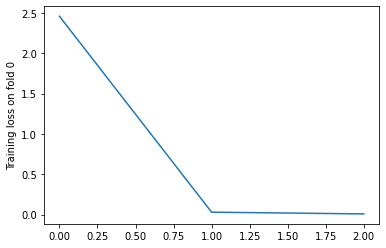

In [ ]:
plt.plot(train_loss_fold0)
plt.ylabel('Training loss on fold 0')
plt.show()

In [ ]:
print('running first fold')
jaccs_fold1, train_loss_fold1 = run(fold=1)

In [ ]:
print('running second fold')
jaccs_fold2, train_loss_fold2 = run(fold=2)

running second fold

======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.09
  Training epcoh took: 1:43:03

Running Validation...
  Average loss on validation data: 0.00
  Average jaccard similarity on validation data: 0.59
  validation took: 1:43:16
saving model

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 1:46:38

Running Validation...
  Average loss on validation data: 0.00
  Average jaccard similarity on validation data: 0.59
  validation took: 1:46:50

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 1:50:11

Running Validation...
  Average loss on validation data: 0.00
  Average jaccard similarity on validation data: 0.59
  validation took: 1:50:23


In [ ]:
print('running third fold')
jaccs_fold3, train_loss_fold3 = run(fold=3)

In [ ]:
print('running fourth fold')
jaccs_fold4, train_loss_fold4 = run(fold=4)

In [ ]:
print('running 5th fold')
jaccs_fold5, train_loss_fold5 = run(fold=5)

In [ ]:
print('running fourth fold')
jaccs_fold6, train_loss_fold6 = run(fold=6)

In [ ]:
jaccs = []
losses = []
jaccs.append(np.mean(np.mean(jaccs_fold0)))
jaccs.append(np.mean(jaccs_fold1))
#jaccs.append(np.mean(jaccs_fold2))
#jaccs.append(np.mean(jaccs_fold3))
#jaccs.append(np.mean(jaccs_fold4))

losses.append(np.mean(np.mean(train_loss_fold0)))
losses.append(np.mean(train_loss_fold1))
#losses.append(np.mean(train_loss_fold2))
#losses.append(np.mean(jaccs_fold3))
#losses.append(np.mean(jaccs_fold4))
jaccs
losses

[0.04989576670227894, 0.04995759922196865]

In [ ]:
print('Jaccard similaritt and train loss average per fold')
data = {'jaccard': jaccs, 'train_loss': losses}
metrics = pd.DataFrame(data)
metrics.to_csv('/content/drive/MyDrive/roberta_metrics.csv')
metrics

Jaccard similaritt and train loss average per fold


,jaccard,train_loss
0,0.589685,0.049896
1,0.589087,0.049958


## Testing the final model

In [ ]:
conf = RobertaConfig.from_pretrained("roberta-base")
conf.output_hidden_states = True

model0 = TextModel(conf)
model0.to(device)
model0 = nn.DataParallel(model0)
model0.load_state_dict(torch.load("/content/drive/MyDrive/RoBERTa_files/model0.pth"))

<All keys matched successfully>

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/RoBERTa_files/test.csv')
test.insert(3,'selected_text', test.text)
test_dataset = TextDataset(text = test.text.values,
                              selected_text = test.selected_text.values,
                              sentiment = test.sentiment.values)

test_dataloader = DataLoader(test_dataset,
                              batch_size = 16,
                              shuffle = False,
                              num_workers=1)
jaccs, pred = evaluate_fn(test_dataloader,model0,device)

  Average loss on validation data: 0.00
  Average jaccard similarity on validation data: 1.00
  validation took: 0:02:30


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/submission.csv')
submission.selected_text = pred
submission.sample(40)

,textID,selected_text
23,f0ef04109b,about to go to sleep
2564,d528912ba9,: nice to see you on twitter!
371,49e9fe8b96,i want to go to singapore but my mother seems...
695,8c08631422,On the phone to mum http://tinyurl.com/otdn9u
1798,198854f289,cannot relaxing because she have to practice ...
3376,9e734c1ed3,I`ll put your name on the list
2386,d276268ebf,Uh-oh...it`s becoming grey again out here. I ...
310,b357b9e7d2,school. 39 days !!! so exited. Amazing premier
3432,d3b70656cd,_marie:my heart goes out to you
857,1e41208494,"alas no, it`s just a normal night monday is q..."


In [ ]:
from google.colab import files
submission.to_csv('submission.csv') 
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### refrence for code
[Roberta one fold](https://www.kaggle.com/abhishek/multiprocessing-roberta-1-fold-per-core)
